# Dataset Preparation and Exploration & Model Benchmarking Against CML

#### Goals of this notebook:
* To ensure that the previously prepared "PHIPS_CrystalHabitAI_Dataset.nc" dataset is effectively used, with preprocessing consistent across classical machine learning (CML) and deep learning models.
* To understand the dataset distribution and domain-specific nuances. Use visualizations and summaries to explore data characteristics.
* To clearly define the problem (classification for ice crystal habit types) and prepare the dataset for deep learning models (e.g., reshaping for CNNs).
* To summarize results from the classical machine learning (CML) models already evaluated (e.g., Random Forest, Gradient Boosting, Logistic Regression).
* To compare classical ML methods with deep learning models using relevant metrics (e.g., Accuracy, F1-score)


## 1.1 AI-Ready Data Utilization
##### Steps:
1. Load the prepared dataset
2. Confirm data preprocessing steps: scaling, normalization, and reshaping where needed.
3. Split the dataset into training, validation, and test sets for deep learning, ensuring consistency.

In [1]:
# Import necessary libraries
import xarray as xr
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
# Load the AI-ready dataset
file_path = 'C:/Users/carpa/Downloads/PHIPS_CrystalHabitAI_Dataset.nc'
ds = xr.open_dataset(file_path)

# Check dataset structure
print(ds)

<xarray.Dataset> Size: 613MB
Dimensions:      (samples: 440, height: 1024, width: 1360)
Coordinates:
  * samples      (samples) int64 4kB 0 1 2 3 4 5 6 ... 434 435 436 437 438 439
Dimensions without coordinates: height, width
Data variables:
    image_array  (samples, height, width) uint8 613MB ...
    timestamp    (samples) <U19 33kB ...
    label        (samples) <U14 25kB ...
    latitude     (samples) float64 4kB ...
    longitude    (samples) float64 4kB ...
    temperature  (samples) float64 4kB ...
    altitude     (samples) float64 4kB ...
Attributes:
    description:    AI-ready dataset for ice crystal habit classification in ...
    creation_date:  2024-10-24
    author:         Valeria Garcia (vgarcia1@uw.edu)


In [3]:
# Extract image data and labels
images = ds['image_array'].values  # Shape: (samples, height, width)
labels = ds['label'].values        # Shape: (samples,)

# Normalize images to [0, 1] range (if not already normalized)
images = images.astype('float32') / 255.0

# Train-Test split (80% train, 10% val, 10% test)
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels) # Temporary Set (X_temp, y_temp): 20% of the data is set aside for further splitting into validation and test sets.
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Print dataset shapes for verification
print(f"Training data: {X_train.shape}, number of images {y_train.shape[0]}")
print(f"Validation data: {X_val.shape}, number of images {y_val.shape[0]}")
print(f"Test data: {X_test.shape}, number of images {y_test.shape[0]}")


Training data: (352, 1024, 1360), number of images 352
Validation data: (44, 1024, 1360), number of images 44
Test data: (44, 1024, 1360), number of images 44


## 1.2 Exploratory Data Analysis (EDA)
##### Steps:
1. Class Distribution: Visualize the number of samples per class.
2. Sample Images: Display example images with corresponding labels.
3. Pixel Value Distribution: Analyze the pixel intensity distribution across images.

C:\Users\carpa\AppData\Local\Temp\ipykernel_25524\1831188940.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_labels, y=label_counts, palette="viridis")


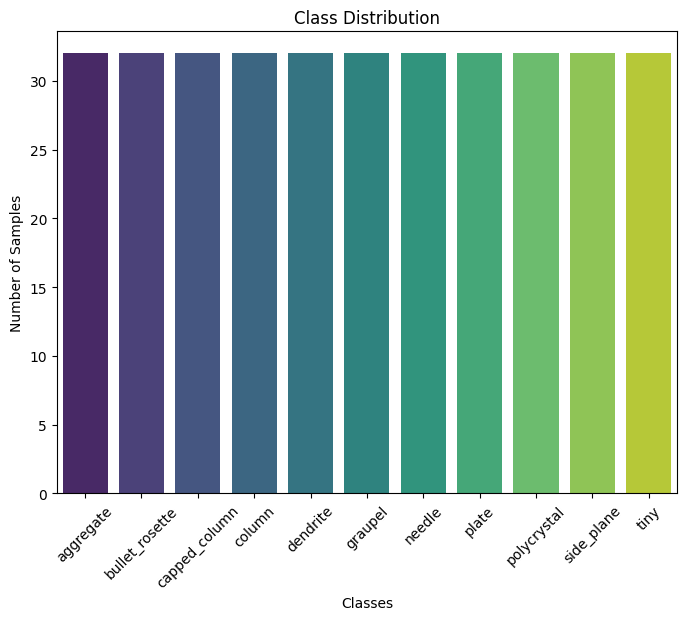

In [4]:
# Plot class distribution
unique_labels, label_counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(8, 6))
sns.barplot(x=unique_labels, y=label_counts, palette="viridis")
plt.xticks(rotation=45)
plt.xlabel("Classes")
plt.ylabel("Number of Samples")
plt.title("Class Distribution")
plt.show()

##### There are an equal number of images for each class, to be expected based on how the "PHIPS_CrystalHabitAI_Dataset.nc" dataset was constructed.

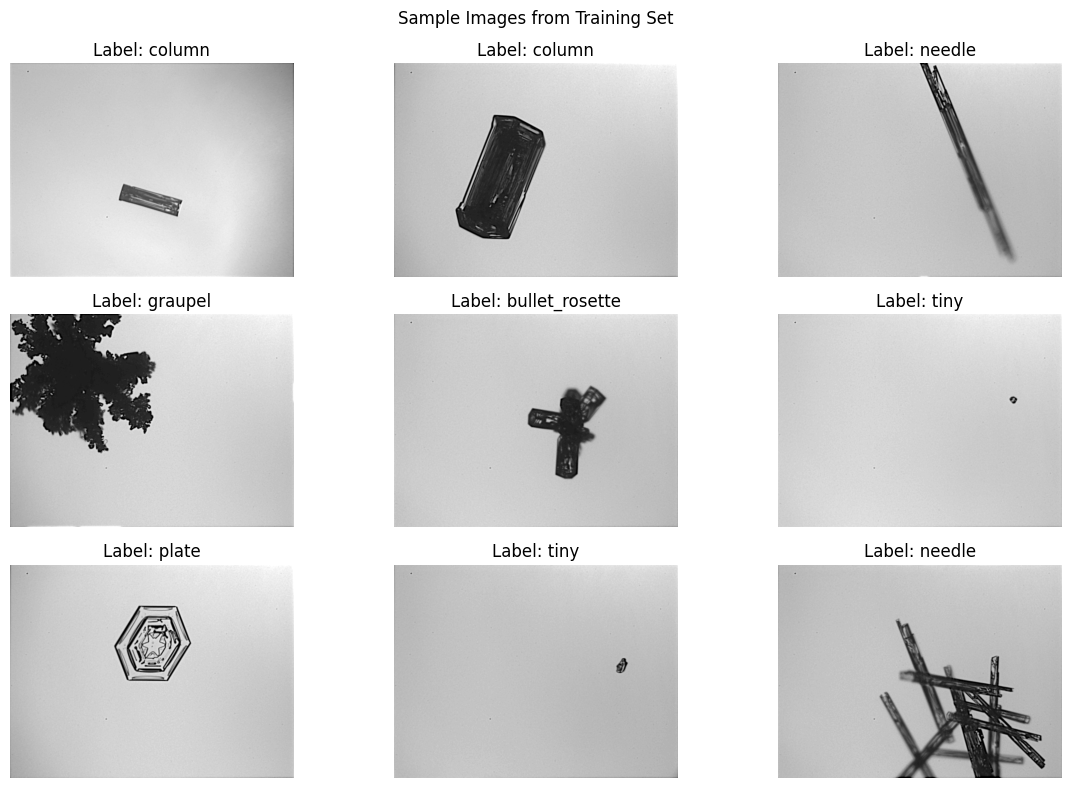

In [5]:
# Display example images
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.suptitle("Sample Images from Training Set")
plt.tight_layout()
plt.show()

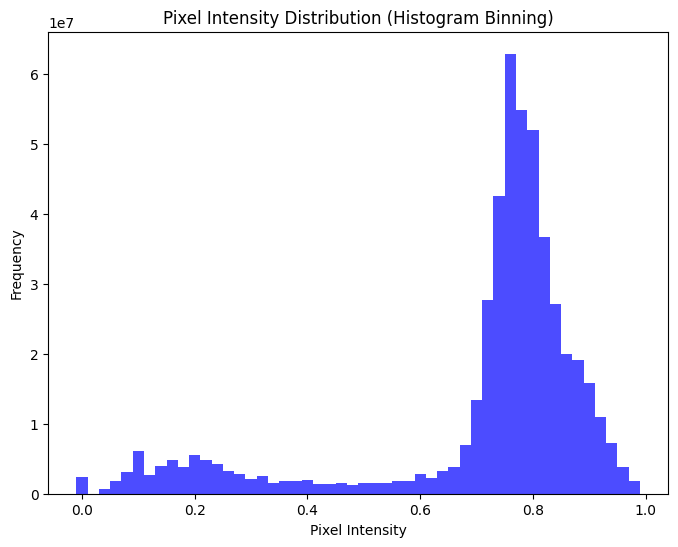

In [6]:
# Compute histogram of pixel intensities across the dataset
hist, bin_edges = np.histogram(X_train, bins=50, range=(0, 1))  # Assuming normalized pixel values

# Plot the pre-computed histogram
plt.figure(figsize=(8, 6))
plt.bar(bin_edges[:-1], hist, width=(bin_edges[1] - bin_edges[0]), color="blue", alpha=0.7)
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.title("Pixel Intensity Distribution (Histogram Binning)")
plt.show()

##### **Observations:** a binomial distribution, with one small peak of lower pixel intensities (high opacity/dark pixels) and the second large peak of high pixel intensities (low opacity, bright pixels). The former is from images with large, opague ice crystals (e.g., aggregates, polycrystals, etc.) and the latter is due to the bright background in all images. 

## 1.3 Problem Setup
##### Steps:
1. Define Problem: This is a multiclass classification problem where the goal is to classify ice crystal images into their corresponding habit type.
2. One-Hot Encode Labels: Convert labels into a format suitable for deep learning.
- The one-hot encoding (to_categorical) converts integer labels into a binary matrix representing class membership.
Example:
If there are 11 classes, label 5 becomes [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0].

3. Prepare for CNNs: Reshape the data to include the channel dimension (`(samples, height, width, channels)`).
- Even though the images are in grayscale and don't have multiple color channels (like RGB), deep learning frameworks such as TensorFlow/Keras still expect a "channel" dimension for compatibility with convolutional neural networks (CNNs). For grayscale images, the "channel" dimension is set to 1, indicating a single channel.

In [7]:
# Pip install necessary libraries
# !pip install tensorflow

In [7]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode string labels into integers
label_encoder = LabelEncoder()
y_train_encoded_labels = label_encoder.fit_transform(y_train)
y_val_encoded_labels = label_encoder.transform(y_val)
y_test_encoded_labels = label_encoder.transform(y_test)

# One-hot encode the integer labels
num_classes = len(np.unique(y_train_encoded_labels))
y_train_encoded = to_categorical(y_train_encoded_labels, num_classes)
y_val_encoded = to_categorical(y_val_encoded_labels, num_classes)
y_test_encoded = to_categorical(y_test_encoded_labels, num_classes)

# Print the mapping of string labels to integers for reference
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Label Mapping (String to Integer):", label_mapping)

# Add channel dimension for CNNs (grayscale images require a single channel)
X_train = np.expand_dims(X_train, axis=-1)  # Shape: (samples, height, width, 1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Print reshaped data for verification
print(f"Training data shape (for CNN): {X_train.shape}")
print(f"Validation data shape (for CNN): {X_val.shape}")
print(f"Test data shape (for CNN): {X_test.shape}")

Label Mapping (String to Integer): {'aggregate': 0, 'bullet_rosette': 1, 'capped_column': 2, 'column': 3, 'dendrite': 4, 'graupel': 5, 'needle': 6, 'plate': 7, 'polycrystal': 8, 'side_plane': 9, 'tiny': 10}
Training data shape (for CNN): (352, 1024, 1360, 1)
Validation data shape (for CNN): (44, 1024, 1360, 1)
Test data shape (for CNN): (44, 1024, 1360, 1)


## 2.1 Baseline Models
##### Display previously obtained classical machine learning metrics computed by PyCaret in `autoML_hyperparameter_tuning.ipynb`

In [8]:
# Results for baseline models
cml_results = {
    'Model': [
        'Random Forest',
        'Gradient Boosting Classifier',
        'Logistic Regression',
        'Extra Trees Classifier',
        'Light Gradient Boosting Machine',
        'Ada Boost Classifier',
        'SVM - Linear Kernel'
    ],
    'Accuracy': [0.38, 0.35, 0.33, 0.36, 0.35, 0.20, 0.17],
    'F1-Score': [0.36, 0.34, 0.31, 0.34, 0.34, 0.12, 0.09],
    'Training Time (s)': [1.48, 1.86, 0.53, 0.10, 491.35, 1.30, 0.06]
}

# Create a summary DataFrame
cml_summary = pd.DataFrame(cml_results)

# Ensure 'Accuracy' column is numeric
cml_summary['Accuracy'] = pd.to_numeric(cml_summary['Accuracy'], errors='coerce')

# Sort the DataFrame by 'Accuracy' in descending order
cml_summary_sorted = cml_summary.sort_values(by='Accuracy', ascending=False)

# Display the styled DataFrame
cml_summary_sorted.style.format(precision=2).set_caption("Baseline Model Performance (Sorted by Accuracy)")

,Model,Accuracy,F1-Score,Training Time (s)
0,Random Forest,0.38,0.36,1.48
3,Extra Trees Classifier,0.36,0.34,0.10
1,Gradient Boosting Classifier,0.35,0.34,1.86
4,Light Gradient Boosting Machine,0.35,0.34,491.35
2,Logistic Regression,0.33,0.31,0.53
5,Ada Boost Classifier,0.20,0.12,1.30
6,SVM - Linear Kernel,0.17,0.09,0.06


As was seen in the CML portion of the project, these models did not perform well, with accuracies not surpassing 40% and F1 scores substantially lower than the desired 1. Training times were competent, except for the Light Gradient Boosting Machine. It was this disappointing performance that motivated the search for a better model, which in theory, should be found on a Neural Network. 

## 2.2 Performance Comparison
##### We will be comparing the CML performances to the following deep learning architectures:
1. Fully Connected Network (FCN): 
* An FCN is a basic neural network consisting only of fully connected layers (dense layers). While it's not ideal for image data due to the lack of spatial awareness, it serves as a baseline for comparing deep learning approaches.

2. Shallow Convolutional Neural Network (CNN): 
* CNNs are the gold standard for image classification tasks. They efficiently learn spatial hierarchies of features (e.g., edges, shapes, textures).

3. Pre-trained ResNet (Transfer Learning): 
* A ResNet includes "residual blocks" to address vanishing gradients and enable very deep networks. While not a "simple" architecture, using a pre-trained ResNet variant (e.g., ResNet-18 or ResNet-50) allows leveraging transfer learning.

4. Recurrent Neural Network (RNN):
* RNNs are sequence-based models typically used for time-series or language tasks. However, they can be adapted for classification by treating the pixel rows of an image as sequential data.

In [9]:
from sklearn.metrics import f1_score, mean_squared_error, classification_report, confusion_matrix, accuracy_score
import time

# Evaluate a model (generalizable to all DL models)
def evaluate_model(model, X_test, y_test_encoded, y_test_encoded_labels):
    from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, accuracy_score
    import numpy as np
    
    # Predict probabilities
    predictions = model.predict(X_test)

    # Handle NaN in predictions
    if np.isnan(predictions).any():
        print("NaN detected in predictions. Replacing with 0.")
        predictions = np.nan_to_num(predictions, nan=0.0)

    # Compute RMSE on probability predictions
    rmse = np.sqrt(mean_squared_error(y_test_encoded, predictions))

    # Convert predictions to class labels
    predicted_labels = np.argmax(predictions, axis=1)

    # Compute classification metrics
    accuracy = accuracy_score(y_test_encoded_labels, predicted_labels)
    report = classification_report(y_test_encoded_labels, predicted_labels, output_dict=True)

    return {
        "accuracy": accuracy,
        "f1_score": report["weighted avg"]["f1-score"],
        "precision": report["weighted avg"]["precision"],
        "recall": report["weighted avg"]["recall"],
        "rmse": rmse
    }

In [10]:
#### 1. Fully Connected Network (FCN) ####

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Define FCN model
fcn_model = Sequential([
    Flatten(input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),  # Flatten the image
    Dense(256, activation='relu'),            # A fully connected layer with 256 neurons and ReLU activation for learning features
    Dropout(0.5),                             # Randomly drops 50% of connections to prevent overfitting
    Dense(128, activation='relu'),            # Another fully connected layer with 128 neurons and ReLU activation
    Dropout(0.5),                             # Additional regularization to reduce overfitting
    Dense(num_classes, activation='softmax')  # Output layer for multiclass classification
])

# Compile the FCN model for training
fcn_model.compile(
    optimizer='adam',                 # Adam optimizer for efficient weight updates
    loss='categorical_crossentropy',  # Loss function for multiclass classification
    metrics=['accuracy']              # Monitor accuracy as the performance metric
)

# Track training time for FCN
start_train_time = time.time()

# Train the FCN model
fcn_history = fcn_model.fit(
    X_train, y_train_encoded,              # Training data and one-hot encoded labels
    validation_data=(X_val, y_val_encoded),# Validation data for performance monitoring
    epochs=2,                             # Number of passes through the entire training dataset
    batch_size=4,                         # Number of samples per gradient update
    verbose=1                              # Print training progress to the console
)

end_train_time = time.time()
fcn_training_time = end_train_time - start_train_time
print(f"FCN Training Time: {fcn_training_time:.2f} seconds")

# Evaluate FCN
fcn_metrics = evaluate_model(fcn_model, X_test, y_test_encoded, y_test_encoded_labels)
fcn_metrics["Training Time (s)"] = fcn_training_time  # Add training time to metrics
print(f"FCN Metrics: {fcn_metrics}")


c:\Users\carpa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
88/88 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.0812 - loss: 1771.5886 - val_accuracy: 0.0909 - val_loss: 4.3659
Epoch 2/2
88/88 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.0426 - loss: 16.9197 - val_accuracy: 0.0909 - val_loss: 2.3985
FCN Training Time: 234.18 seconds
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
FCN Metrics: {'accuracy': 0.09090909090909091, 'f1_score': 0.01515151515151515, 'precision': 0.008264462809917356, 'recall': 0.09090909090909091, 'rmse': 0.2874832082541817, 'Training Time (s)': 234.18441009521484}


c:\Users\carpa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\carpa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\carpa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [ ]:
#### 2. Shallow Convolutional Neural Network (CNN) ####

from tensorflow.keras.layers import Conv2D, MaxPooling2D

# Define shallow CNN model
shallow_cnn_model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),  # First convolutional layer with 16 filters and ReLU activation
    MaxPooling2D((2, 2)),       # Max pooling to reduce spatial dimensions
    Conv2D(32, (3, 3), activation='relu'),  # Second convolutional layer with 32 filters and ReLU activation
    MaxPooling2D((2, 2)),       # Additional max pooling for further down-sampling
    Flatten(),                  # Flatten the output for fully connected layers
    Dense(64, activation='relu'),  # Fully connected layer with 64 neurons and ReLU activation
    Dense(num_classes, activation='softmax')  # Output layer with softmax for multiclass classification
])

# Compile the shallow CNN model
shallow_cnn_model.compile(
    optimizer='adam',                 # Adam optimizer for adaptive learning rates
    loss='categorical_crossentropy',  # Loss function for multiclass classification
    metrics=['accuracy']              # Monitor accuracy as a performance metric
)

# Track training time for the shallow CNN
start_train_time = time.time()

# Train the shallow CNN
shallow_cnn_history = shallow_cnn_model.fit(
    X_train, y_train_encoded,              # Training data and one-hot encoded labels
    validation_data=(X_val, y_val_encoded),# Validation data for performance monitoring
    epochs=10,                             # Number of training epochs
    batch_size=32,                         # Number of samples per gradient update
    verbose=1                              # Print training progress to the console
)

end_train_time = time.time()
cnn_training_time = end_train_time - start_train_time
print(f"CNN Training Time: {cnn_training_time:.2f} seconds")

# Evaluate CNN
cnn_metrics = evaluate_model(shallow_cnn_model, X_test, y_test_encoded, y_test_encoded_labels)
cnn_metrics["Training Time (s)"] = cnn_training_time  # Add training time to metrics
print(f"CNN Metrics: {cnn_metrics}")

c:\Users\carpa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [ ]:
#### 3. Pre-trained ResNet (Transfer Learning) ####
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.preprocessing.image import smart_resize
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

# Convert grayscale images to RGB
# Grayscale images have a single channel, but ResNet50 requires 3-channel RGB images.
# We repeat the single grayscale channel three times to simulate an RGB image.
X_train_rgb = np.repeat(X_train, 3, axis=-1)  # Repeat grayscale channel along the last axis
X_val_rgb = np.repeat(X_val, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)

# Verify the shape of the converted data
print(f"Training data shape after RGB conversion: {X_train_rgb.shape}")
print(f"Validation data shape after RGB conversion: {X_val_rgb.shape}")
print(f"Test data shape after RGB conversion: {X_test_rgb.shape}")

# Load the pre-trained ResNet50 model without the top layer
# `weights='imagenet'` loads pre-trained weights from ImageNet.
# `include_top=False` excludes the fully connected layers at the top of the model.
# `input_shape=(height, width, 3)` specifies the input dimensions, now with 3 channels.
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(X_train_rgb.shape[1], X_train_rgb.shape[2], 3))

# Add custom layers for classification
# `GlobalAveragePooling2D` reduces the spatial dimensions to 1 by averaging across each feature map.
# A Dense layer with 128 units learns complex patterns from the extracted features.
# The final Dense layer outputs `num_classes` probabilities (softmax for multiclass classification).
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduce spatial dimensions to a single vector
x = Dense(128, activation='relu')(x)  # Fully connected layer for learning features
predictions = Dense(num_classes, activation='softmax')(x)  # Output layer for class probabilities

# Create the full model
# The model combines the pre-trained ResNet base and the custom classification layers.
resnet_model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base layers for transfer learning
# Pre-trained ResNet layers are frozen to retain learned features from ImageNet.
# Only the custom layers added above will be trained initially.
for layer in base_model.layers:
    layer.trainable = False

# Compile the ResNet model
# `optimizer='adam'` is used for efficient weight updates during training.
# `loss='categorical_crossentropy'` is the loss function for multiclass classification.
# `metrics=['accuracy']` monitors the accuracy during training and evaluation.
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Track training time for the ResNet model
# Start the timer to measure how long training takes.
start_train_time = time.time()

# Train the ResNet model
# `X_train_rgb` is the RGB-converted training data.
# `y_train_encoded` contains the one-hot encoded labels.
# `validation_data` specifies the validation set to monitor performance during training.
# `epochs=10` trains the model for 10 passes through the dataset.
# `batch_size=32` processes 32 samples at a time during training.
resnet_history = resnet_model.fit(
    X_train_rgb, y_train_encoded,
    validation_data=(X_val_rgb, y_val_encoded),
    epochs=10,
    batch_size=32,
    verbose=1  # Print training progress
)

# Stop the timer to calculate training time
end_train_time = time.time()
resnet_training_time = end_train_time - start_train_time
print(f"ResNet Training Time: {resnet_training_time:.2f} seconds")

# Evaluate the ResNet model
resnet_metrics = evaluate_model(resnet_model, X_test_rgb, y_test_encoded, y_test_encoded_labels)

# Add training time to the evaluation metrics
resnet_metrics["Training Time (s)"] = resnet_training_time
print(f"ResNet Metrics: {resnet_metrics}")

Training data shape after RGB conversion: (352, 1024, 1360, 3)
Validation data shape after RGB conversion: (44, 1024, 1360, 3)
Test data shape after RGB conversion: (44, 1024, 1360, 3)
Epoch 1/10


In [ ]:
#### 4. Recurrent Neural Network (RNN) ####

from tensorflow.keras.preprocessing.image import smart_resize
import time
import numpy as np

# Step 1: Resize images (reduce spatial dimensions to 128x128)
# Use the existing dataset with channel dimension already added
# smart_resize expects images with channel dimensions (height, width, channels)
X_train_resized = np.array([smart_resize(img, (128, 128)) for img in X_train])
X_val_resized = np.array([smart_resize(img, (128, 128)) for img in X_val])
X_test_resized = np.array([smart_resize(img, (128, 128)) for img in X_test])

# Verify the resized dimensions
print(f"Resized training data shape: {X_train_resized.shape}")
print(f"Resized validation data shape: {X_val_resized.shape}")
print(f"Resized test data shape: {X_test_resized.shape}")

Resized training data shape: (352, 128, 128, 1)
Resized validation data shape: (44, 128, 128, 1)
Resized test data shape: (44, 128, 128, 1)


In [15]:
# Reshape the data for RNN input
X_train_rnn = X_train_resized.reshape(X_train_resized.shape[0], -1, 1)  # Shape: (samples, timesteps, features)
X_val_rnn = X_val_resized.reshape(X_val_resized.shape[0], -1, 1)
X_test_rnn = X_test_resized.reshape(X_test_resized.shape[0], -1, 1)

# Verify the reshaped dimensions
print(f"Training data shape for RNN: {X_train_rnn.shape}")
print(f"Validation data shape for RNN: {X_val_rnn.shape}")
print(f"Test data shape for RNN: {X_test_rnn.shape}")

Training data shape for RNN: (352, 16384, 1)
Validation data shape for RNN: (44, 16384, 1)
Test data shape for RNN: (44, 16384, 1)


In [ ]:
from tensorflow.keras.layers import SimpleRNN

# Define the RNN model
# Input shape: (timesteps, features)
rnn_model = Sequential([
    SimpleRNN(128, activation='relu', input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),  # RNN layer with 128 units
    Dense(64, activation='relu'),  # Dense layer with 64 neurons
    Dense(num_classes, activation='softmax')  # Output layer for multiclass classification
])

# Compile the RNN model
# Optimizer: Adam; Loss function: categorical crossentropy; Metric: accuracy
rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Track training time
start_train_time = time.time()

# Train the RNN
# Uses reshaped training data and validates performance on validation set
rnn_history = rnn_model.fit(
    X_train_rnn,               # Training data
    y_train_encoded,           # One-hot encoded training labels
    validation_data=(X_val_rnn, y_val_encoded),  # Validation data and labels
    epochs=10,                 # Number of epochs
    batch_size=8,              # Batch size
    verbose=1                  # Display detailed progress during training
)

# Calculate training time
end_train_time = time.time()
rnn_training_time = end_train_time - start_train_time
print(f"RNN Training Time: {rnn_training_time:.2f} seconds")  # Output training time

# Evaluate the RNN on test data
rnn_metrics = evaluate_model(rnn_model, X_test_rnn, y_test_encoded, y_test_encoded_labels)

# Add training time to the evaluation metrics
rnn_metrics["Training Time (s)"] = rnn_training_time
print(f"RNN Metrics: {rnn_metrics}")  # Display evaluation metrics

/home/disk/meso-home/vgarcia1/anaconda3/envs/impacts/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.0812 - loss: 2.4051 - val_accuracy: 0.1136 - val_loss: 2.3962
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.1258 - loss: nan - val_accuracy: 0.0909 - val_loss: nan
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.0848 - loss: nan - val_accuracy: 0.0909 - val_loss: nan
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.0892 - loss: nan - val_accuracy: 0.0909 - val_loss: nan
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.0850 - loss: nan - val_accuracy: 0.0909 - val_loss: nan
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.1053 - loss: nan - val_accuracy: 0.0909 - val_loss: nan
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.1238 - loss: nan - val_accuracy: 0.0909 - val_loss: nan
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.1110 - loss: nan - val_accuracy: 0.0909 - val_loss: nan
Epoch 9/10
44/44 ━━━━━━━━━━━━━━━━━

/home/disk/meso-home/vgarcia1/anaconda3/envs/impacts/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/disk/meso-home/vgarcia1/anaconda3/envs/impacts/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/disk/meso-home/vgarcia1/anaconda3/envs/impacts/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [17]:
# Metrics for each architecture
metrics_data = {
    "Model": ["Fully Connected Network (FCN)", "Convolutional Neural Network (CNN)", 
              "ResNet (Transfer Learning)", "Recurrent Neural Network (RNN)"],
    "Accuracy": [fcn_metrics["accuracy"], cnn_metrics["accuracy"], 
                 resnet_metrics["accuracy"], rnn_metrics["accuracy"]],
    "F1-Score": [fcn_metrics["f1_score"], cnn_metrics["f1_score"], 
                 resnet_metrics["f1_score"], rnn_metrics["f1_score"]],
    "Training Time (s)": [fcn_metrics["Training Time (s)"], cnn_metrics["Training Time (s)"], 
                          resnet_metrics["Training Time (s)"], rnn_metrics["Training Time (s)"]],
    "Precision": [fcn_metrics["precision"], cnn_metrics["precision"], 
                  resnet_metrics["precision"], rnn_metrics["precision"]],
    "Recall": [fcn_metrics["recall"], cnn_metrics["recall"], 
               resnet_metrics["recall"], rnn_metrics["recall"]]
}

# Create a DataFrame to display the metrics
metrics_df = pd.DataFrame(metrics_data)

# Display the table
metrics_df.style.format(precision=4).set_caption("Comparison of Model Architectures")


,Model,Accuracy,F1-Score,Training Time (s),Precision,Recall
0,Fully Connected Network (FCN),0.0682,0.0116,296.6339,0.0063,0.0682
1,Convolutional Neural Network (CNN),0.2727,0.2079,1181.9341,0.2369,0.2727
2,ResNet (Transfer Learning),0.1364,0.0659,5833.4353,0.0556,0.1364
3,Recurrent Neural Network (RNN),0.0909,0.0152,767.8323,0.0083,0.0909


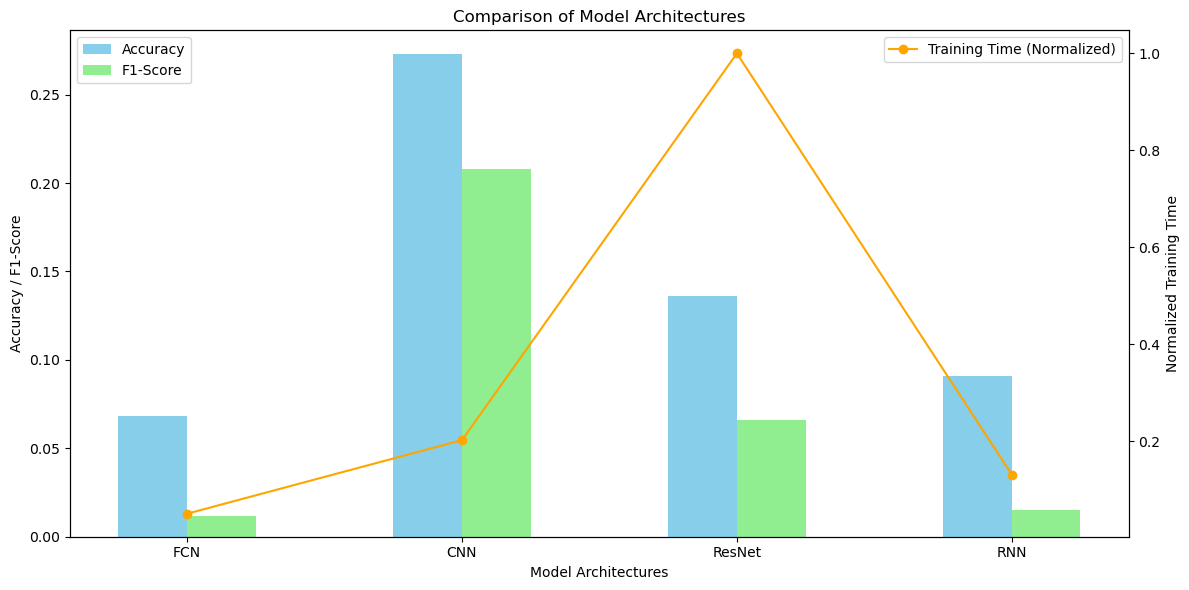

In [18]:
# Data for visualization
models = ["FCN", "CNN", "ResNet", "RNN"]
accuracy = [fcn_metrics["accuracy"], cnn_metrics["accuracy"], resnet_metrics["accuracy"], rnn_metrics["accuracy"]]
f1_score = [fcn_metrics["f1_score"], cnn_metrics["f1_score"], resnet_metrics["f1_score"], rnn_metrics["f1_score"]]
training_time = [fcn_metrics["Training Time (s)"], cnn_metrics["Training Time (s)"], resnet_metrics["Training Time (s)"], rnn_metrics["Training Time (s)"]]

# Normalizing training time for better visualization
training_time_normalized = [t / max(training_time) for t in training_time]

# Set bar width
bar_width = 0.25
x = np.arange(len(models))  # X-axis positions

# Create subplots for different metrics
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot accuracy and F1-score as bars
ax1.bar(x - bar_width / 2, accuracy, width=bar_width, label="Accuracy", color="skyblue")
ax1.bar(x + bar_width / 2, f1_score, width=bar_width, label="F1-Score", color="lightgreen")

# Plot normalized training time as a line
ax2 = ax1.twinx()
ax2.plot(x, training_time_normalized, label="Training Time (Normalized)", color="orange", marker="o")

# Customize axes and add labels
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.set_xlabel("Model Architectures")
ax1.set_ylabel("Accuracy / F1-Score")
ax2.set_ylabel("Normalized Training Time")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# Add a title
plt.title("Comparison of Model Architectures")
plt.tight_layout()
plt.show()


Surprisingly, all neural network-based models have a worse performance than those of classic Machine Learning, as the maximum accuracy was barely over 27%. Precision and recall were equally incompetent, never surpassing 30%. These models are even more alarming than the baselines, as their training times were excessively long, ranging from around 5 to 140 minutes. However, these models were a basic inspection of neural networks, so hyperparameter tuning and further architecture explorations, which will be explored in the following section, should hopefully yield better results. 